In [59]:
import numpy as np
import pandas as pd
import tempfile
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import yaml

import common
import vcm

from fv3fit.train_microphysics import TrainConfig

In [2]:
base = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1"

In [3]:
url = common.get_group_url("zc-emu-monthly-normfix-m{init}-seed3-30d-v1-offline".format(init="01"))

No state saved for online runs.  Check offline instead.

In [4]:
precpd_rnn_path = "gs://vcm-ml-experiments/microphysics-emulation/2022-12-16/zc-train-precpd-seed5-v2"
model = tf.keras.models.load_model(f"{precpd_rnn_path}/model.tf")

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond', 'air_temperature_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [5]:
def load_model_config(path):
    with tempfile.TemporaryDirectory() as tmpdir:
        dst = f"{tmpdir}/config.yaml"
        !gsutil cp {path}/config.yaml {dst}
        with open(dst, "r") as f:
            d = yaml.safe_load(f)
            d.pop("seed")
            d.pop("loss")
        return TrainConfig.from_dict(d)

cfg = load_model_config(precpd_rnn_path)

Copying gs://vcm-ml-experiments/microphysics-emulation/2022-12-16/zc-train-precpd-seed5-v2/config.yaml...
/ [1 files][  3.8 KiB/  3.8 KiB]                                                
Operation completed over 1 objects/3.8 KiB.                                      


In [6]:
test = cfg.open_dataset(cfg.test_url, None, required_variables=cfg.model_variables | {"cloud_water_mixing_ratio_after_precpd"})
test = cfg.prepare_flat_data(test)

In [7]:
profiles = next(iter(test.shuffle(180_000).batch(100_000)))


In [8]:

transform = cfg.build_transform(profiles)

In [9]:
target = transform.backward(transform.forward(profiles))

In [10]:
predictions = model.predict(profiles, batch_size=512)

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['air_temperature_after_precpd', 'specific_humidity_after_precpd', 'cloud_water_mixing_ratio_after_precpd'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond', 'air_temperature_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [11]:
def plot_hexbin_dist(T, q, title, ax, q_condition=None, vmax=3e4, ylabel="dq [kg/kg/s]", xlabel="Temperature [K]", **kwargs):
    
    if q_condition=="neg":
        condition = q < 0
    elif q_condition=="pos":
        condition = q > 0
    else:
        condition = q != 0
            
    T = T[condition]
    q = q[condition]
    
    
    coll = ax.hexbin(abs(T), abs(np.array(q)), yscale="log", cmap="Greens", gridsize=150, bins="log", vmin=1, vmax=vmax, **kwargs)
    plt.colorbar(coll, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [12]:
list(target.keys())

['air_temperature_after_gscond',
 'surface_air_pressure',
 'cloud_water_mixing_ratio_after_gscond',
 'air_pressure',
 'cloud_water_mixing_ratio_input',
 'air_temperature_after_last_gscond',
 'pressure_thickness_of_atmospheric_layer',
 'specific_humidity_input',
 'specific_humidity_after_last_gscond',
 'surface_air_pressure_after_last_gscond',
 'air_temperature_input',
 'air_temperature_after_precpd',
 'specific_humidity_after_precpd',
 'specific_humidity_after_gscond',
 'cloud_water_mixing_ratio_after_precpd',
 'log_cloud_input',
 'log_humidity_input',
 'log_humidity_after_last_gscond',
 'cloud_precpd_difference',
 'temperature_precpd_difference',
 'humidity_precpd_difference',
 'relative_humidity']

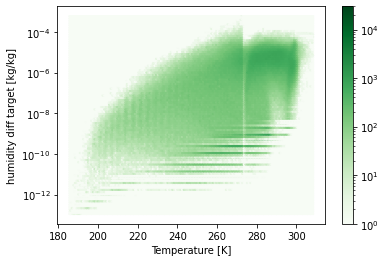

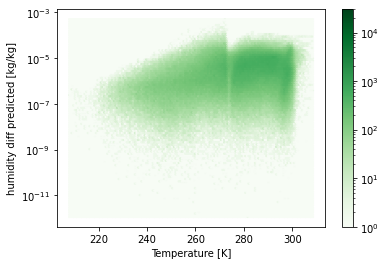

In [13]:
fig, ax = plt.subplots()
plot_hexbin_dist(profiles["air_temperature_input"], target["humidity_precpd_difference"], "", ax, ylabel="humidity diff target [kg/kg]")

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], predictions["humidity_precpd_difference"], "", ax, ylabel="humidity diff predicted [kg/kg]")

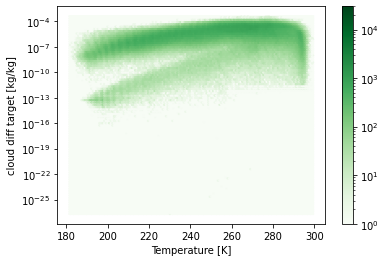

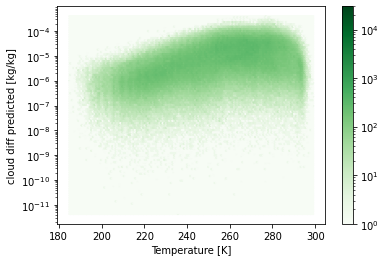

In [14]:
fig, ax = plt.subplots()
plot_hexbin_dist(profiles["air_temperature_input"], target["cloud_precpd_difference"], "", ax, ylabel="cloud diff target [kg/kg]")

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], predictions["cloud_precpd_difference"], "", ax, ylabel="cloud diff predicted [kg/kg]")

## Arctic stratosphere only
compare target vs. what the predicted fractions are

In [15]:
arctic_test = cfg.open_dataset(cfg.train_url, nfiles=None, required_variables=set(cfg.model_variables | {"latitude", "cloud_water_mixing_ratio_after_gscond"}))
arctic_test = cfg.prepare_flat_data(arctic_test)

In [16]:
def limit_arc(d):
    arc_out = {}
    mask = np.squeeze(np.rad2deg(d["latitude"]) > 60)
    for k, v in d.items():
        arc_out[k] = v.numpy()[mask]

    return arc_out


combined_arc = {}
for b in iter(arctic_test.shuffle(150_000).batch(10_000)):
    limited = limit_arc(b)
    for k, v in limited.items():
        prev_b = combined_arc.get(k, [])
        combined = np.concatenate(prev_b + [v], axis=0)
        combined_arc[k] = [combined]
    
    if combined.shape[0] > 100_000:
        break

combined_arc = {k: v[0] for k, v in combined_arc.items()}


In [17]:
def limit_non_arc(d):
    out = {}
    lat_deg = np.squeeze(np.rad2deg(d["latitude"]))
    mask =  np.logical_and(lat_deg <= 60, lat_deg >= -60)
    for k, v in d.items():
        out[k] = v.numpy()[mask]

    return out

combined_non_arc = {}
for b in iter(arctic_test.shuffle(150_000).batch(10_000)):
    limited = limit_non_arc(b)
    for k, v in limited.items():
        prev_b = combined_non_arc.get(k, [])
        combined = np.concatenate(prev_b + [v], axis=0)
        combined_non_arc[k] = [combined]
    
    if combined.shape[0] > 100_000:
        break

combined_non_arc = {k: v[0] for k, v in combined_non_arc.items()}

In [18]:
def get_target_prediction(model, transform, profiles):
    predict = model.predict(profiles, batch_size=512)
    target = transform.backward(transform.forward(profiles))
    return target, predict

In [19]:
arc_target, arc_precpd = get_target_prediction(model, transform, combined_arc)


/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['air_temperature_after_precpd', 'cloud_water_mixing_ratio_after_precpd', 'latitude', 'specific_humidity_after_precpd'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond', 'air_temperature_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [107]:
def get_pred_metrics(target, prediction, axis=None):
    diff = (target - prediction)
    mse = np.nanmean(diff**2, axis=axis)
    skill = 1 - (mse/(np.nanmean(target**2, axis=axis)))
    bias = np.mean(diff, axis=axis)
    return np.sqrt(mse), bias, skill


def plot_classifier_adjusted(target, prediction, strato=False, vmax=1.5e4, strato_slice=(-29, -11)):
    target_dq = target["humidity_precpd_difference"].numpy()/900
    pred_dq = prediction["humidity_precpd_difference"]/900
    T_in = target["air_temperature_input"]

    if strato:
        target_dq = target_dq[..., slice(*strato_slice)]
        pred_dq = pred_dq[..., slice(*strato_slice)]
        T_in = T_in[..., slice(*strato_slice)]

    figsize = (6,4)
    dpi = 120
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, target_dq, "Target dq distribution", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq, "Predicted dq distribution", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq)))

    

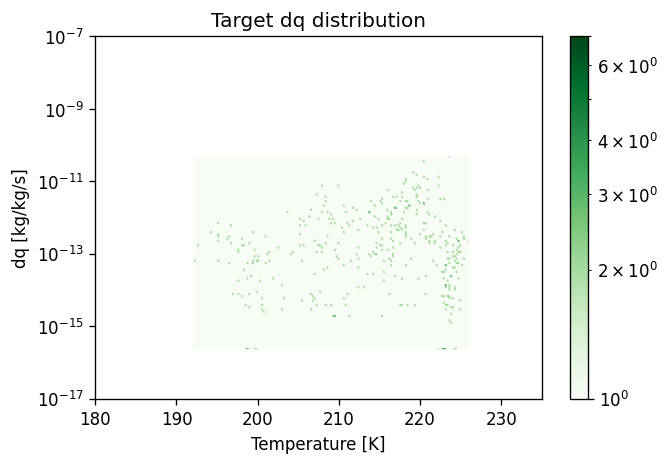

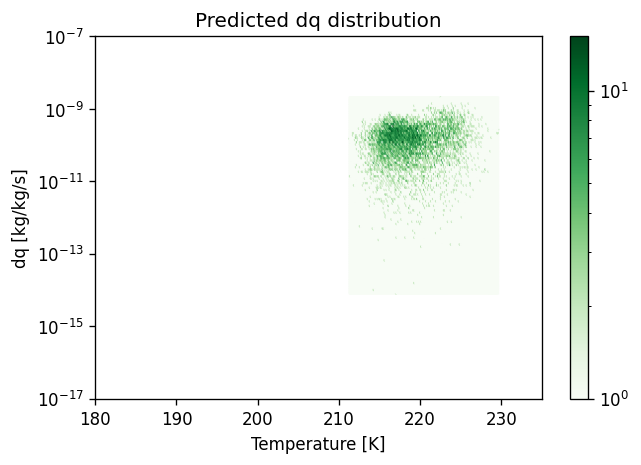

rmse=2.12e-11, bias=-1.32e-12, skill=-82573.33


In [111]:
plot_classifier_adjusted(arc_target, arc_precpd, strato=True, vmax=None)

## What about for non-polar regions?

In [22]:
non_arc_target, non_arc_precpd = get_target_prediction(model, transform, combined_non_arc)

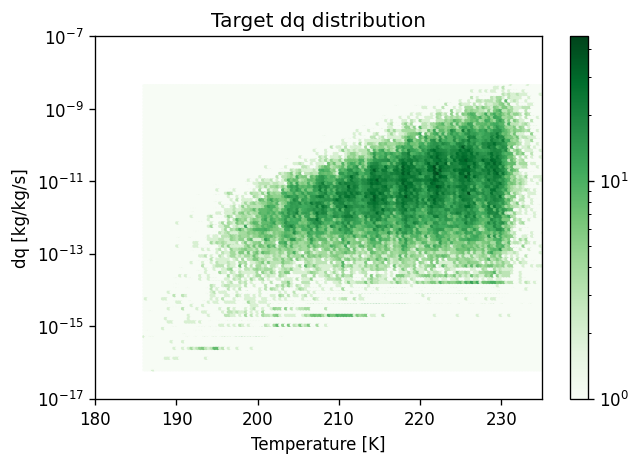

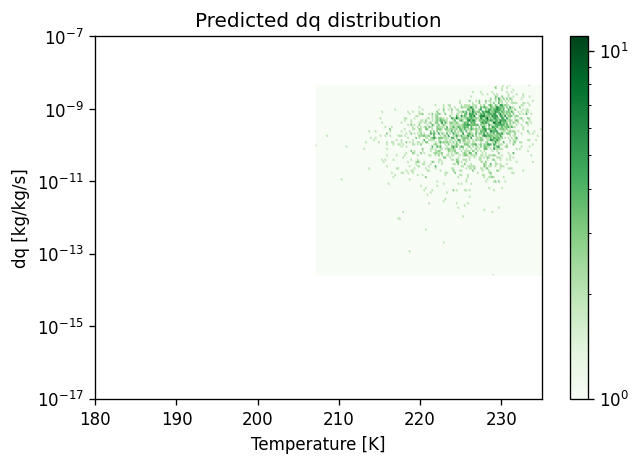

rmse=1.19e-11, bias=6.15e-13, skill=0.85


In [23]:
plot_classifier_adjusted(non_arc_target, non_arc_precpd, strato=True, vmax=None)

## Where is the RMS floor?

In [56]:
data = common.open_group(base.format(init="06") + "-offline")

In [42]:
data.z.values[11:29][::-1]

array([238.1392495 , 223.35284664, 209.01518984, 195.14426047,
       181.75662065, 168.86695212, 156.48798547, 144.6306775 ,
       133.30382408, 122.51386604, 112.26527242, 102.56003799,
        93.39779834,  84.77603123,  76.68981971,  69.13199422,
        62.09317351,  55.56185435])

In [26]:
arc_dq_targ = arc_target["humidity_precpd_difference"][:, -29:-11]
non_arc_dq_targ = non_arc_target["humidity_precpd_difference"][:, -29:-11]
arc_dq_pred = arc_precpd["humidity_precpd_difference"][:, -29:-11]
non_arc_dq_pred = non_arc_precpd["humidity_precpd_difference"][:, -29:-11]

In [30]:
arc_mse = ((arc_dq_pred - arc_dq_targ)**2).numpy().mean(axis=0)
non_arc_mse = ((non_arc_dq_pred - non_arc_dq_targ)**2).numpy().mean(axis=0)
arc_ms = (arc_dq_targ**2).numpy().mean(axis=0)
non_arc_ms = (non_arc_dq_targ**2).numpy().mean(axis=0)

In [34]:
arc_target.keys()

dict_keys(['surface_air_pressure', 'cloud_water_mixing_ratio_after_gscond', 'air_pressure', 'cloud_water_mixing_ratio_input', 'air_temperature_after_last_gscond', 'pressure_thickness_of_atmospheric_layer', 'surface_air_pressure_after_last_gscond', 'air_temperature_input', 'air_temperature_after_precpd', 'cloud_water_mixing_ratio_after_precpd', 'air_temperature_after_gscond', 'specific_humidity_input', 'specific_humidity_after_last_gscond', 'latitude', 'specific_humidity_after_precpd', 'specific_humidity_after_gscond', 'log_cloud_input', 'log_humidity_input', 'log_humidity_after_last_gscond', 'cloud_precpd_difference', 'temperature_precpd_difference', 'humidity_precpd_difference', 'relative_humidity'])

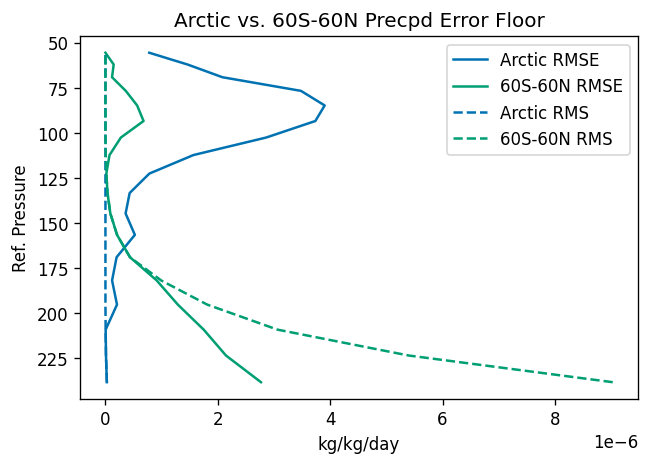

In [55]:
scale_factor = 60**2 * 24 / 900  # kg/kg/day

plt.figure(dpi=120)
l1, = plt.plot(np.sqrt(arc_mse)*scale_factor, data.z.values[11:29][::-1], label="Arctic RMSE")
l2, = plt.plot(np.sqrt(non_arc_mse)*scale_factor, data.z.values[11:29][::-1], label="60S-60N RMSE")
plt.plot(np.sqrt(arc_ms)*scale_factor, data.z.values[11:29][::-1], label="Arctic RMS", linestyle="--", color=l1.get_color())
plt.plot(np.sqrt(non_arc_ms)*scale_factor, data.z.values[11:29][::-1], label="60S-60N RMS", linestyle="--", color=l2.get_color())
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel("Ref. Pressure")
plt.xlabel("kg/kg/day")
plt.title("Arctic vs. 60S-60N Precpd Error Floor")
plt.show()

In [69]:
total_emu = "tendency_of_specific_humidity_due_to_zhao_carr_emulator"
total_phys = "tendency_of_specific_humidity_due_to_zhao_carr_physics"
gscond_emu = "tendency_of_specific_humidity_due_to_gscond_emulator"
gscond_phys = "tendency_of_specific_humidity_due_to_gscond_physics"

sq_err = ((data[total_emu] - data[gscond_emu]) - (data[total_phys] - data[gscond_phys]))**2
sq = (data[total_phys] - data[gscond_phys])**2

sq_err_zonal = vcm.zonal_average_approximate(data.lat, sq_err.mean("time"))
sq_zonal = vcm.zonal_average_approximate(data.lat, sq.mean("time"))

In [63]:
import dask

client = dask.distributed.Client()

In [70]:
rmse_zonal = np.sqrt(sq_err_zonal).load()
rms_zonal = np.sqrt(sq_zonal).load()

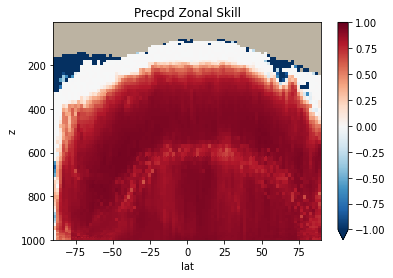

In [81]:
(1 - rmse_zonal/rms_zonal).plot(y="z", x="lat", vmin=-1, vmax=1, yincrease=False, cmap="RdBu_r")
plt.title("Precpd Zonal Skill")
plt.show()

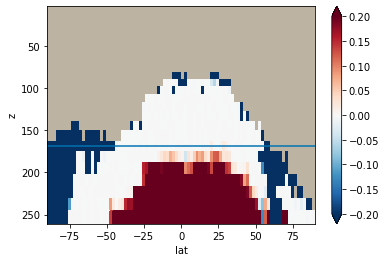

In [85]:
(1 - rmse_zonal/rms_zonal).isel(z=slice(30)).plot(y="z", x="lat", vmin=-0.2, vmax=0.2, yincrease=False, cmap="RdBu_r")
plt.axhline(rms_zonal.z[23])
plt.show()

In [86]:
pressure = vcm.zonal_average_approximate(data.lat, data["pressure_thickness_of_atmospheric_layer"].cumsum("z") + 300).load()

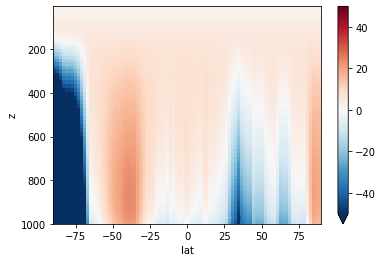

In [93]:
(pressure.mean("time")/100 - pressure.z).plot(y="z", yincrease=False, vmin=-50, vmax=50, cmap="RdBu_r")
plt.show()

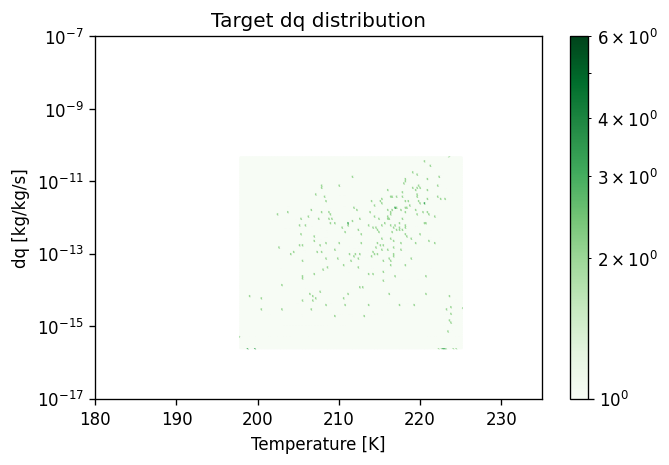

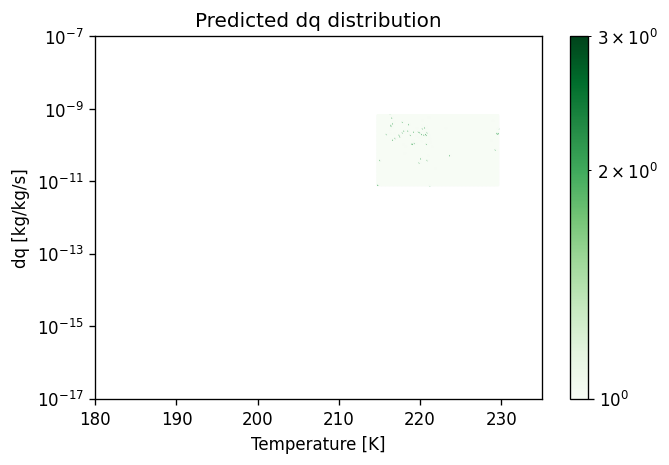

rmse=2.66e-12, bias=-2.27e-14, skill=-506.57


In [108]:
plot_classifier_adjusted(arc_target, arc_precpd, strato=True, vmax=None, strato_slice=(-29, -22))

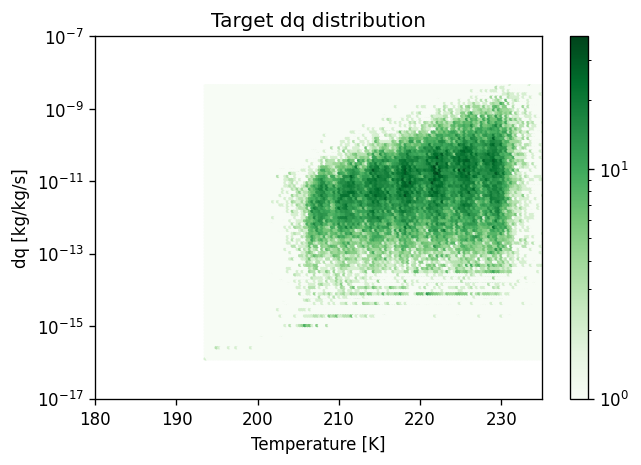

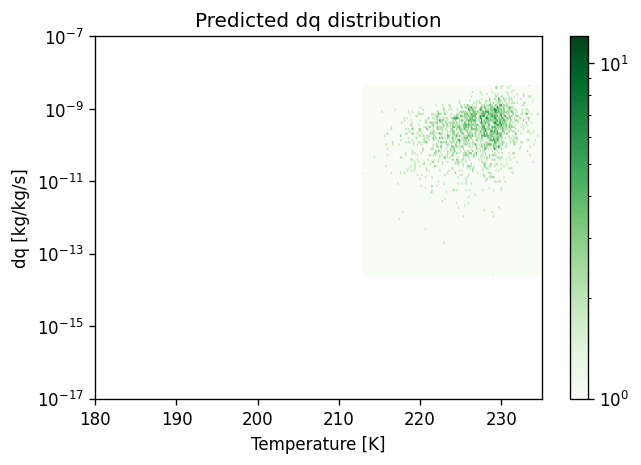

rmse=1.86e-11, bias=1.63e-12, skill=0.86


In [109]:
plot_classifier_adjusted(non_arc_target, non_arc_precpd, strato=True, vmax=None, strato_slice=(-29, -22))

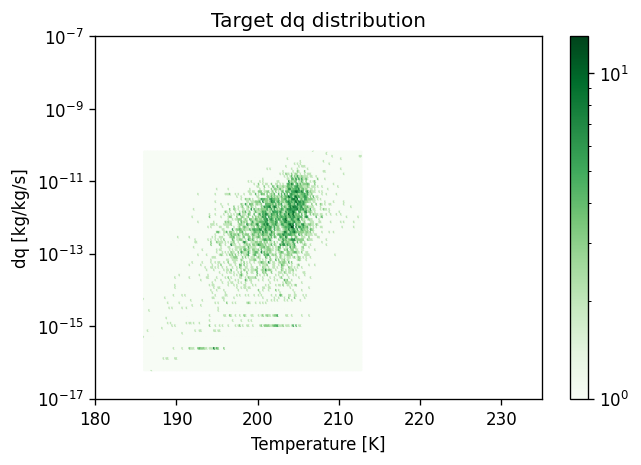

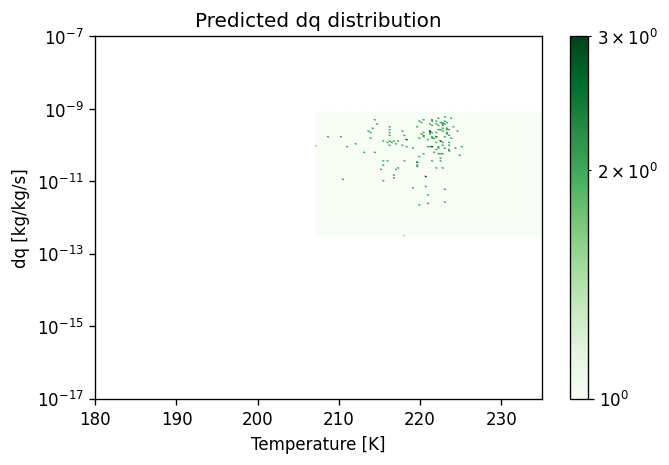

rmse=2.68e-12, bias=-1.72e-14, skill=-126.64


In [110]:
plot_classifier_adjusted(non_arc_target, non_arc_precpd, strato=True, vmax=None, strato_slice=(-22, None))

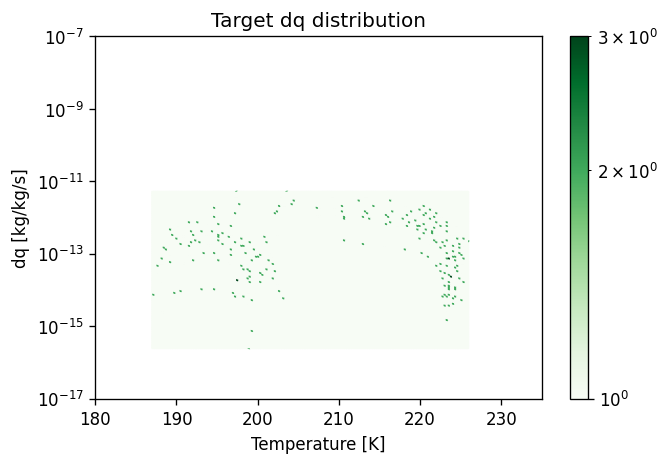

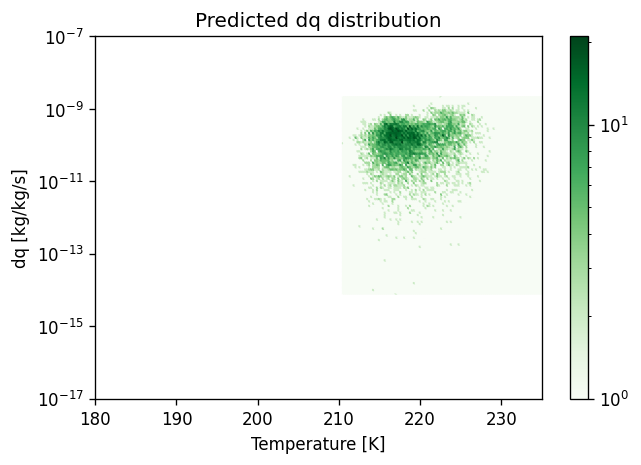

rmse=1.92e-11, bias=-1.08e-12, skill=-2445142.75


In [112]:
plot_classifier_adjusted(arc_target, arc_precpd, strato=True, vmax=None, strato_slice=(-22, None))